In [1]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, ADAM
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

from qclib.machine_learning.datasets import digits

algorithm_globals.random_seed = 42

In [2]:
# Dataset load.
seed = 42

# Here you can choose the dataset classes. For example: [0,1], [1,8], [2,4,7], etc.
# At least two classes must be chosen.
sample_total, training_input, test_input, class_labels = digits.load(classes=[0, 1],
                                                                     training_size=160,
                                                                     test_size=10,
                                                                     random_seed=seed)
feature_dim = len(training_input[class_labels[0]][0])

In [3]:
train_images = np.concatenate([train_samples for _, train_samples in training_input.items()])
test_images = np.concatenate([test_samples for _, test_samples in test_input.items()])
test_labels = np.concatenate([[test_label] * len(test_samples) for test_label, test_samples in test_input.items()])

In [4]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

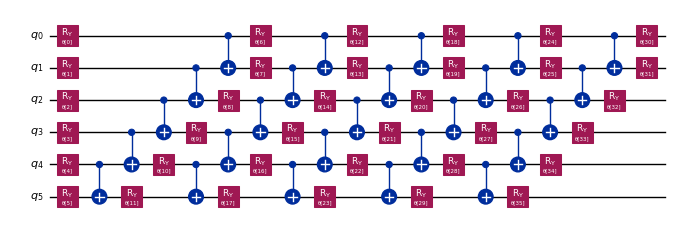

In [5]:
num_latent = 3
num_trash = 3
num_qubits = num_latent + num_trash

circ = ansatz(num_qubits)
circ.decompose().draw("mpl", scale=0.5, style="iqp")

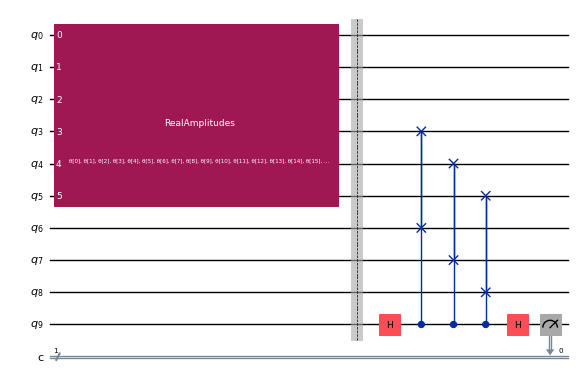

In [6]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw("mpl", scale=0.5, style="iqp")

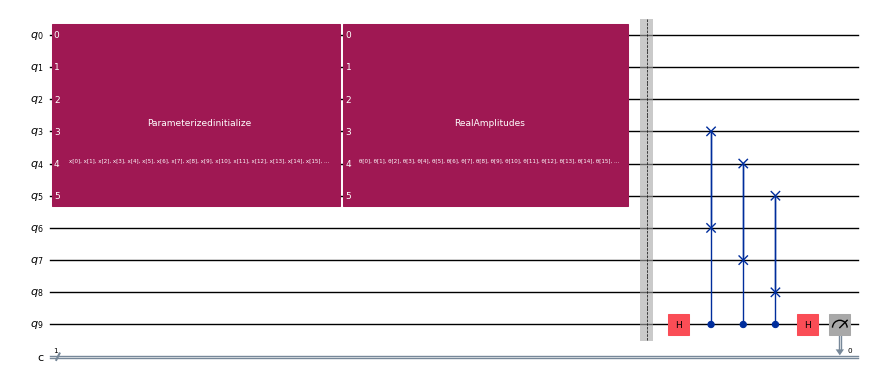

In [7]:
fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw("mpl", scale=0.5, style="iqp")

In [8]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [9]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

In [10]:
initial_point = algorithm_globals.random.random(ae.num_parameters)

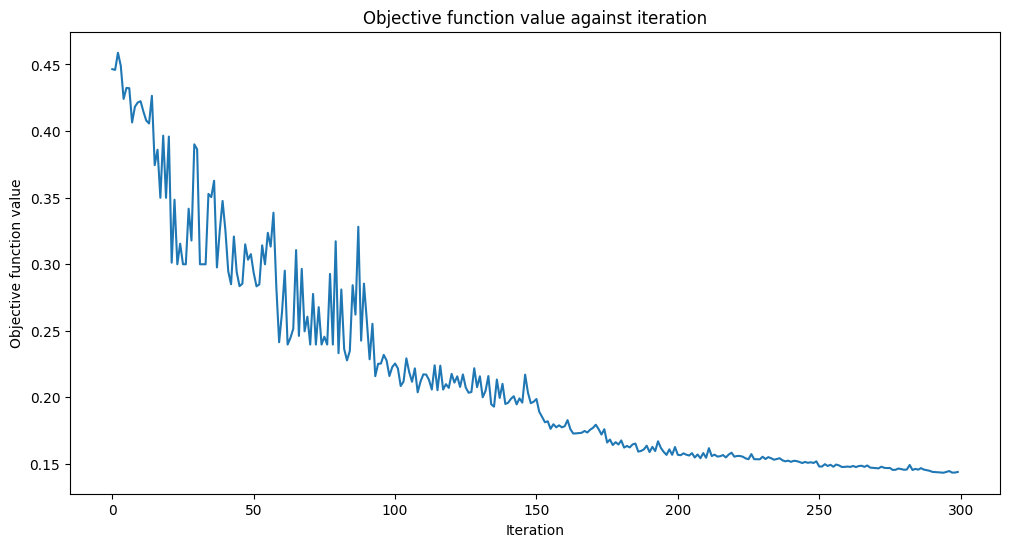

Fit in 581.46 seconds


In [11]:
opt = COBYLA(maxiter=300)
# opt = ADAM(maxiter=300)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

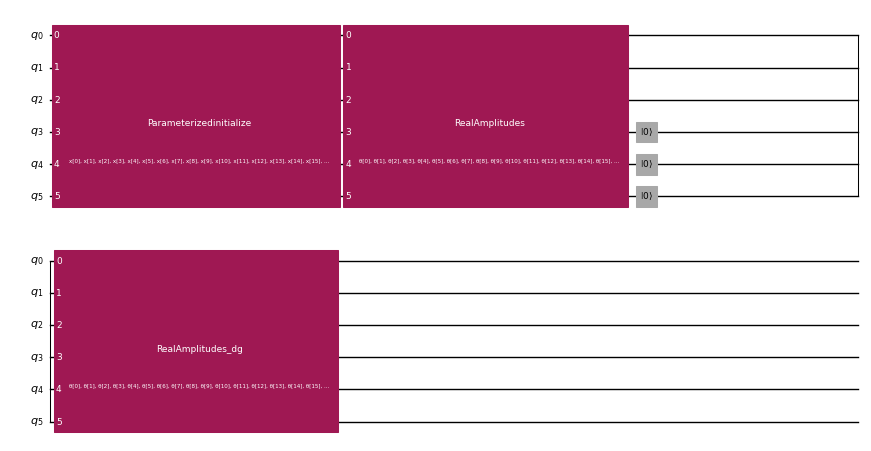

In [12]:
# Utility functions.
def calc_fidelity(state1, state2):
    bra = np.conj(state1)
    ket = state2

    return np.power(np.abs(bra.dot(ket)), 2)

def plot_digits(vectors, num_data_qubits, text=''):
    import matplotlib.pyplot as plt
    _dpi = 96
    matrix_dim_1 = 2**(int(np.ceil(num_data_qubits/2)))
    matrix_dim_2 = 2**(int(np.floor(num_data_qubits/2)))

    ncols = len(vectors)
    _, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*10*matrix_dim_1/_dpi, 10*matrix_dim_2/_dpi), dpi=_dpi)
    for ax, vector in zip(axes, vectors):
        ax.set_axis_off()
        image = vector.reshape(matrix_dim_1, matrix_dim_2)
        ax.imshow(image, cmap=plt.cm.gray, interpolation='none')

    plt.show()

# Test
ansatz_qc = ansatz(num_latent + num_trash)

test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
test_qc = test_qc.compose(ansatz_qc)
test_qc.reset(range(num_qubits-num_trash, num_qubits))
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw('mpl', scale=0.5, style="iqp")

0 - Recovered state fidelity = 0.8451100648295933


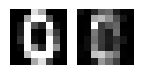

1 - Recovered state fidelity = 0.7478828953787673


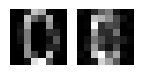

2 - Recovered state fidelity = 0.877968021629939


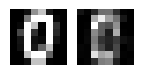

3 - Recovered state fidelity = 0.8177042771482494


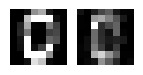

4 - Recovered state fidelity = 0.7410818391309002


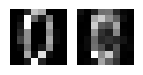

5 - Recovered state fidelity = 0.837449564086262


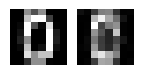

6 - Recovered state fidelity = 0.7634532188406061


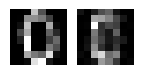

7 - Recovered state fidelity = 0.6192341155347006


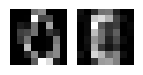

8 - Recovered state fidelity = 0.7532642643993454


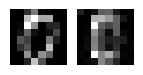

9 - Recovered state fidelity = 0.7576975755677643


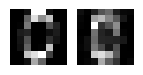

10 - Recovered state fidelity = 0.6653610702416454


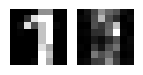

11 - Recovered state fidelity = 0.639632669038521


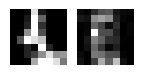

12 - Recovered state fidelity = 0.07905515043707954


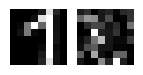

13 - Recovered state fidelity = 0.658176299269142


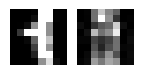

14 - Recovered state fidelity = 0.5945073486306657


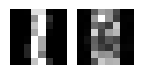

15 - Recovered state fidelity = 0.6578176499673551


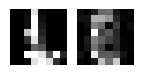

16 - Recovered state fidelity = 0.4952255751114425


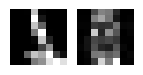

17 - Recovered state fidelity = 0.7364341769734613


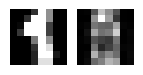

18 - Recovered state fidelity = 0.7997678540991333


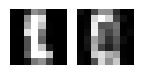

19 - Recovered state fidelity = 0.44615538648896674


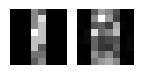

In [13]:
# sample new images
for i, (image, label) in enumerate(zip(test_images, test_labels)):
    original_qc = fm.assign_parameters(image)
    original_state = Statevector(original_qc).data
    original_probs = Statevector(original_qc).probabilities()

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    
    # There is a sporadic bug in the reset.
    # For now, I've decided to run the same piece of code five
    # times to avoid it, but at some point it will be necessary
    # to investigate the problem.
    output_probs = None
    fidelity = 0.0
    for _ in range(5):
        _output_state = Statevector(output_qc).data
        _fidelity = calc_fidelity(original_state, _output_state)
        if _fidelity > fidelity:
            fidelity = _fidelity
            output_probs = np.abs(_output_state)**2

    vectors = [original_probs, output_probs]
    print(i, '- Recovered state fidelity =', fidelity)
    plot_digits(vectors, 6, text='')